In [2]:
# importing all the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
import cv2 as cv2
from numpy import random 


import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset,random_split, DataLoader
from torch.autograd import Variable
from torchvision import datasets, transforms 
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.model_selection import train_test_split
import os
from os import listdir
from os.path import isfile, join
from PIL import Image
import skimage as ski
from skimage.transform import resize
import random




In [3]:
# mounting the drive where our data is stored

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#1 Visualize 5 random samples of both classes


In [4]:
# paths of the class folders

infected_path = "/content/drive/MyDrive/DL_A2/original/Parasitized"
uninfected_path = "/content/drive/MyDrive/DL_A2/original/Uninfected"

# list of image names for both classes
infect_ls = listdir(infected_path) 
uninfect_ls = listdir(uninfected_path) 


In [5]:
len(infect_ls),len(uninfect_ls)

(13780, 13780)

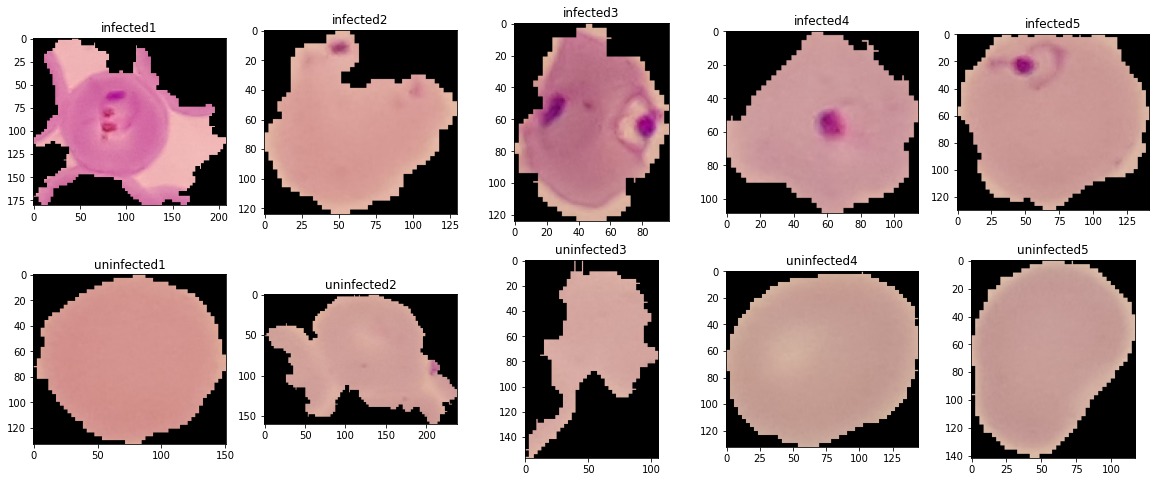

In [8]:
# plotting 5 random samples from each class

fig,ax = plt.subplots(2,5,figsize=(20,8))

# list to store 5 unique indexes randomly in range 0 to 100
# this list is used to access the images of both our classes
indexes = []

while len(indexes)<5:  
  id = random.randint(0, 100)
 
  # if the generated number is already present in the index list 
  # again generate one in order to get 5 unique random numbers 
  while id in indexes:
      id = random.randint(0,100)
  
  # appending into the list
  indexes.append(id)
          

for i in range(5):
  # accessing the infected image at ith index from the list of infected images
  img = plt.imread(infected_path+"/"+infect_ls[indexes[i]])
  
  # plotting ith infected image
  ax[0][i].imshow(img)
  ax[0][i].set_title("infected"+str(i+1))


  # accessing the infected image at ith index from the list of infected images
  img = plt.imread(uninfected_path+"/"+uninfect_ls[indexes[i]])
  
  # plotting ith uninfected image
  ax[1][i].imshow(img)
  ax[1][i].set_title("uninfected"+str(i+1))

#Splitting data into Train,test, validation sets

In [6]:
# preparing the dataset for our torch model


# transformation to be applied on our data
data_transform = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor()
        ])

# loading the dataset and applying the transformation on it
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/DL_A2/original/',
                                           transform=data_transform)


In [7]:
# setting all the random seeds to 0 so as to prevent the 
# degree of randomness in our pipeline as much as possible

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

g = torch.Generator()
g.manual_seed(0)


In [8]:
# finding the sizes of the train, validation and test set to be
# used further for splitting the dataset into these sets

# total length of data
dataset_size = len(dataset)

# test size  = 10% of the entire data
test_size = int(0.1 * dataset_size)

# validation size  = 10% of the entire data (same as test size)
val_size = test_size

# train size  = 80% of the entire data or the remaining data
train_size = dataset_size - test_size-val_size

# reducing train size to half for faster execution
train_size //= 2

print(test_size,val_size,train_size)

2755 2755 11024


In [9]:
# preparing the dataloader for our training pipeline

# random list of indexes used to split the 
# shuffled data into train, test and validation sets
indices = list(range(dataset_size))
np.random.shuffle(indices)

# getting indexes for all sets
test_index = indices[:test_size]
val_index = indices[test_size:2*test_size]
train_index =  indices[-train_size:]

# making sampler to generate random samples for the sets
train_sampler = SubsetRandomSampler(train_index,generator=g)
test_sampler = SubsetRandomSampler(test_index,generator=g)
val_sampler = SubsetRandomSampler(val_index,generator=g)

# finally defining the dataloader for train, validation and test sets

batch_size= 512
train_loader = DataLoader(dataset, sampler=train_sampler, 
                          batch_size=batch_size,generator=g)

val_loader = DataLoader(dataset, sampler=val_sampler,
                        batch_size=batch_size,generator=g)

test_loader = DataLoader(dataset, sampler=test_sampler,
                         batch_size=batch_size,generator=g)

len(train_index),len(test_index),len(val_index)

(11024, 2755, 2755)

In [10]:
# finding the training mean and standard deviation 
# that will be used to normalize data before training 
train_data = next(iter(train_loader))
train_mean, train_std = train_data[0].mean([0,2,3]), train_data[0].std([0,2,3])

print(train_mean, train_std)

tensor([0.5300, 0.4237, 0.4540]) tensor([0.3302, 0.2665, 0.2827])


In [13]:
# normalized version of the dataset for our torch model

# added normalization to the transformation
data_transform_Normalized = transforms.Compose([
        transforms.Resize((64,64)),                                        
        transforms.ToTensor(),
        transforms.Normalize(train_mean,train_std)
        ])

# loading the dataset and applying the transformation on it
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/DL_A2/original/',
                                           transform=data_transform_Normalized)


batch_size= 512
train_loader = DataLoader(dataset, sampler=train_sampler, 
                          batch_size=batch_size,generator=g)

val_loader = DataLoader(dataset, sampler=val_sampler,
                        batch_size=batch_size,generator=g)

test_loader = DataLoader(dataset, sampler=test_sampler,
                         batch_size=batch_size,generator=g)

len(train_index),len(test_index),len(val_index)

(11024, 2755, 2755)

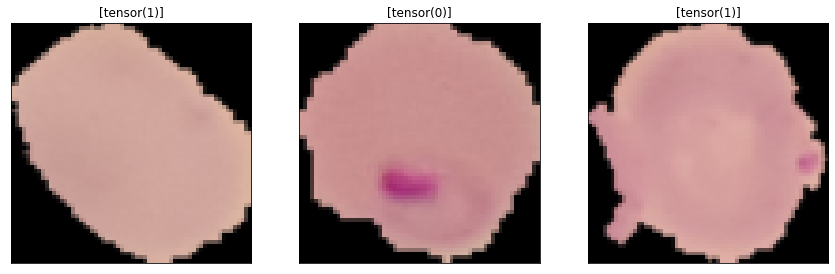

In [16]:
# printing images for checking our dataloader

def imshow(img):
    # modified imshow which first unnormalize the image then displays it
    img = img *0.2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

# getting images and their labels from training set's dataloader 
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(25, 15))

# displaying the image
for i in range(3):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[], title=[labels[i]])
    imshow(images[i])
plt.show()


In [15]:
len(train_loader), len(test_loader), len(val_loader)

(22, 6, 6)

In [16]:
# check if gpu is available or not 
# if it is present, shift to it for faster computation
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [20]:
# methods for trainig tha testing our model

def fit(model, step_size, train_loader,val_loader):

    # optimizer to be used for our task
    optimizer = torch.optim.Adam(model.parameters(),lr=step_size) 
    
    # loss criterion as per binary classification task
    Loss = nn.BCELoss()
    
    # number of epochs used for training
    EPOCHS = 15
  
    model.train()

    # list to store the training and validation loss and accuracies per epoch
    train_loss, val_loss = [],[]            # loss lists
    train_acc_ls, val_acc_ls = [],[]        # accuracy lists


    for epoch in range(EPOCHS):
        print("epoch : ",epoch)

        # variables to count the correct and total training samples per batch
        correct,total = 0,0

        # running training and validation loss (loss per epoch)
        training_loss,validation_loss = 0,0

        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            # if gpu is available shift to it
            X_batch,y_batch = X_batch.to(device),y_batch.to(device)
           
            optimizer.zero_grad()

            output = model(torch.tensor(X_batch,dtype=torch.float32))
            y_batch = y_batch.float()
                                
            # calculate loss
            loss = Loss(output,y_batch.reshape(-1,1))

            # based on the regularization criteria 
            # update the loss value accordingly
            if model.regularization=="L2":
              l2_val = sum(p.pow(2.0).sum()
                            for p in model.parameters())
              
              loss = loss + model.alpha * l2_val
            
            elif model.regularization=="L1":
              l1_val = sum(p.abs().sum()
                            for p in model.parameters())

              loss = loss + model.alpha  * l1_val

            loss.backward()
            optimizer.step()

            # Total correct predictions for the batch
            correct += (y_batch.cpu().detach().numpy()==output.reshape(-1).cpu().detach().numpy().round()).sum()
            total += X_batch.size()[0]
            # print("correct: ",correct,"total: ",total)

            # running training loss
            training_loss += loss.item() * X_batch.size()[0]
            
            print('\tLoss:{} \t Accuracy:{:.3f}%'.format(loss.item(),  float(correct*100) / total ))  
        
        # training accuracy for a epoch
        train_acc= float(correct*100) / total
        

        ##########################
        ##      validation      ##
        ##########################

        # variables to count the correct and total validation samples per batch
        correct,total = 0,0

        if not val_loader == None:
          # to set the model in test mode
          model.eval()
        
          for batch_idx,  (X_batch, y_batch) in enumerate(val_loader):
              X_batch,y_batch = X_batch.to(device),y_batch.to(device)
              
              output = model(X_batch)

              y_batch = y_batch.float()
                                
              #calculate loss
              loss = Loss(output,y_batch.reshape(-1,1))

              correct += (y_batch.cpu().detach().numpy()==output.reshape(-1).cpu().detach().numpy().round()).sum()
              total += X_batch.size()[0]

              # running validation loss
              validation_loss += loss.item() * X_batch.size()[0]

        # validation accuracy for a epoch
        val_acc= float(correct*100) / total

        print('Train Loss:{} \t Train Accuracy:{:.3f}%'.format(training_loss/len(train_loader.dataset)
                                                        ,train_acc ))
        print('Val Loss:{} \t Validation Accuracy:{:.3f}%'.format(validation_loss/len(val_loader.dataset),
                                                       val_acc))
        
        # appending losses per epoch
        train_loss.append(training_loss/len(train_loader.dataset))
        val_loss.append(validation_loss/len(val_loader.dataset))

        # appending accuracies per epoch
        train_acc_ls.append(train_acc)
        val_acc_ls.append(val_acc) 

    # saving the model
    torch.save(model.state_dict(), "/"+ model.model_name + '.pkl')

    # returning training and validation loss and accuracies per epochs 
    return train_loss,val_loss,train_acc_ls,val_acc_ls


def test(model, test_loader):
    # variables to count the correct and total test samples   
    correct,total = 0 ,0

    for test_imgs, test_labels in test_loader:
        # shift to gpu
        test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
       
        output = model(torch.tensor(test_imgs,dtype=torch.float32))
        test_labels =  test_labels.float()

        correct += (test_labels.cpu().detach().numpy()==output.cpu().reshape(-1).detach().numpy().round()).sum()
        total += test_imgs.size()[0]

    # printing the test accuracy
    print("Test accuracy:{}% ".format(100*(correct/ total))  )
  



In [3]:
# class for our convolution neural network

class CNN(nn.Module):
    def __init__(self,intialization,name,dropout_control=0,regularization=None,alpha=0):
        super(CNN, self).__init__()

        # defining the convolution layers
        self.conv1 = nn.Conv2d(3,5, kernel_size=9)  # block A
        self.conv2 = nn.Conv2d(5,7, kernel_size=6)  # block B
        self.conv3 = nn.Conv2d(7,8, kernel_size=3)  # block C
        
        # dropout layer
        self.dropout1 = nn.Dropout(0.5)
        
        # defining the fully connnected layers
        self.fc1 = nn.Linear(3528, 50)
        self.fc2 = nn.Linear(50, 1)

        # regularization criteria to be used for training
        self.regularization = regularization

        # setting the regularization parameter if regularization is to be used
        if not self.regularization == None:
          self.alpha = alpha
        else:
          self.alpha = 0

        # initializing the weights of the model based on the criteria to be used
        self.Initialize(intialization)
        
        # setting the dropout control to be used        
        # 1 for after convolution layer 
        # 2 for between fully connected layer      
        self.dropout_control = dropout_control

        # setting the model name to be used while saving in its path 
        self.model_name = name


    def forward(self, x):
        x = self.conv1(x)
        # print("conv1: ",x.size())
       
        x = F.max_pool2d(x,2)
        # print("max pool: ",x.size())
       
        x = self.conv2(x)
        # print("conv2: ",x.size())
        
        x = self.conv3(x)
        # print("conv3: ",x.size())
        
        if self.dropout_control==1:
          # apply dropout after convolution layers
          x = self.dropout1(x)

        x = torch.flatten(x, 1)
        # print("flatten: ",x.size())
        
        x = self.fc1(x)
        # print("fc1 :",x.size())

        if self.dropout_control==2:
          # apply dropout between fully connected layer
          x = self.dropout1(x)

        x = self.fc2(x)
        # # print("fc2 :",x.size())
        
        # aplpying the sigmoid at the output layer
        output = torch.sigmoid(x)
        return output


    def Initialize(self,method):
      # method to initialize the weights of the model based the criteria passed
      
      # zero intialization
      if method == "zero":
        self.conv1.weight.data.fill_(0.)
        self.conv2.weight.data.fill_(0.)
        self.conv3.weight.data.fill_(0.)
        self.fc1.weight.data.fill_(0.)
        self.fc2.weight.data.fill_(0.)
      
      # random intialization
      elif method == "random":
        nn.init.normal_(self.conv1.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.conv2.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.conv3.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.fc1.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0.0, std=0.01)

      # He intialization
      elif method == "He":
        nn.init.kaiming_uniform_(self.conv1.weight)
        nn.init.kaiming_uniform_(self.conv2.weight)
        nn.init.kaiming_uniform_(self.conv3.weight)
        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight)

 

In [5]:
CNN("zero",'zero_cnn')

CNN(
  (conv1): Conv2d(3, 5, kernel_size=(9, 9), stride=(1, 1))
  (conv2): Conv2d(5, 7, kernel_size=(6, 6), stride=(1, 1))
  (conv3): Conv2d(7, 8, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3528, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)

In [23]:
"""
  model with
    zero weight initialization
    learnning rate = 0.001
"""
zero_cnn = CNN("zero",'zero_cnn',dropout_control=0).to(device)

train_loss_ls, val_loss_ls,train_acc_ls,val_acc_ls = fit(zero_cnn , 0.001 , train_loader,val_loader)

test(zero_cnn,test_loader)


epoch :  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


	Loss:0.693754255771637 	 Accuracy:47.656%
	Loss:0.6925283670425415 	 Accuracy:50.391%
	Loss:0.694161057472229 	 Accuracy:49.154%
	Loss:0.693168044090271 	 Accuracy:49.414%
	Loss:0.6926316022872925 	 Accuracy:50.078%
	Loss:0.6929563283920288 	 Accuracy:50.260%
	Loss:0.693508505821228 	 Accuracy:50.028%
	Loss:0.6928707361221313 	 Accuracy:50.220%
	Loss:0.6936070919036865 	 Accuracy:50.000%
	Loss:0.6927502751350403 	 Accuracy:50.215%
	Loss:0.6934463977813721 	 Accuracy:50.089%
	Loss:0.6936798095703125 	 Accuracy:49.870%
	Loss:0.6933904886245728 	 Accuracy:49.745%
	Loss:0.6926144361495972 	 Accuracy:49.930%
	Loss:0.6923165321350098 	 Accuracy:50.143%
	Loss:0.6907366514205933 	 Accuracy:50.366%
	Loss:0.6842790842056274 	 Accuracy:50.620%
	Loss:0.6824300289154053 	 Accuracy:50.727%
	Loss:0.6864843964576721 	 Accuracy:50.833%
	Loss:0.6742227077484131 	 Accuracy:51.182%
	Loss:0.6614359617233276 	 Accuracy:51.962%
	Loss:0.6720966100692749 	 Accuracy:52.268%
Train Loss:0.2756012892963596 	 Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test accuracy:69.21960072595282% 


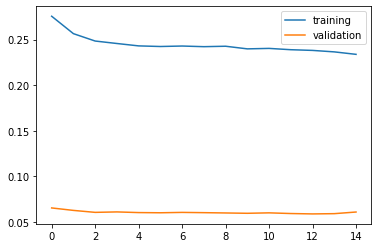

In [24]:
plt.plot(train_loss_ls,label ="training")
plt.plot(val_loss_ls,label='validation')
plt.legend()


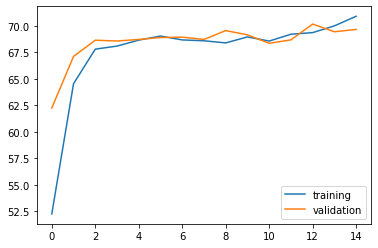

In [25]:
plt.plot(train_acc_ls,label ="training")
plt.plot(val_acc_ls,label='validation')
plt.legend()

In [26]:
"""
  model with
    random weight initialization
    learnning rate = 0.001
"""
random_cnn = CNN("random",'random_cnn',dropout_control=0).to(device)

train_loss_ls, val_loss_ls,train_acc_ls,val_acc_ls = fit(random_cnn , 0.01 , train_loader,val_loader)

test(random_cnn,test_loader)


epoch :  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


	Loss:0.6936541795730591 	 Accuracy:50.977%
	Loss:1.0332183837890625 	 Accuracy:50.195%
	Loss:0.7644555568695068 	 Accuracy:48.177%
	Loss:0.7312588691711426 	 Accuracy:48.096%
	Loss:4.867259979248047 	 Accuracy:48.711%
	Loss:0.965660572052002 	 Accuracy:47.526%
	Loss:1.5830085277557373 	 Accuracy:47.349%
	Loss:4.254209518432617 	 Accuracy:47.754%
	Loss:0.781807005405426 	 Accuracy:48.394%
	Loss:0.7533460855484009 	 Accuracy:47.656%
	Loss:2.72625470161438 	 Accuracy:48.082%
	Loss:2.3450891971588135 	 Accuracy:48.242%
	Loss:2.6036417484283447 	 Accuracy:48.813%
	Loss:3.5101003646850586 	 Accuracy:48.870%
	Loss:0.814975917339325 	 Accuracy:49.414%
	Loss:0.7120984792709351 	 Accuracy:49.585%
	Loss:1.5969994068145752 	 Accuracy:49.782%
	Loss:0.8495299816131592 	 Accuracy:49.403%
	Loss:1.7216771841049194 	 Accuracy:49.445%
	Loss:1.4268975257873535 	 Accuracy:49.521%
	Loss:0.7355290651321411 	 Accuracy:49.572%
	Loss:0.7587177157402039 	 Accuracy:49.619%
Train Loss:0.6664981279692237 	 Train A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test accuracy:69.36479128856624% 


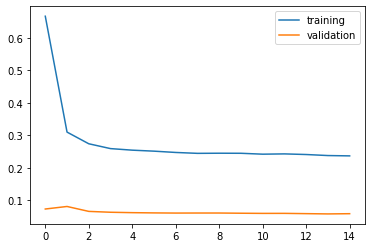

In [27]:
plt.plot(train_loss_ls,label ="training")
plt.plot(val_loss_ls,label='validation')
plt.legend()


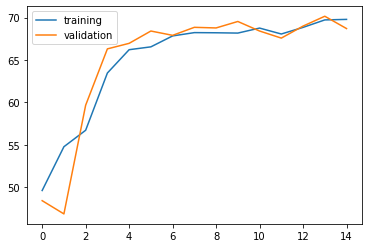

In [28]:
plt.plot(train_acc_ls,label ="training")
plt.plot(val_acc_ls,label='validation')
plt.legend()

In [29]:
"""
  model with
    He weight initialization
    learnning rate = 0.001
"""
He_cnn = CNN("He",'He_cnn',dropout_control=0).to(device)

train_loss_ls, val_loss_ls,train_acc_ls,val_acc_ls = fit(He_cnn , 0.001 , train_loader,val_loader)

test(He_cnn,test_loader)


epoch :  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


	Loss:1.5782203674316406 	 Accuracy:48.438%
	Loss:41.02035903930664 	 Accuracy:48.145%
	Loss:38.69828796386719 	 Accuracy:48.633%
	Loss:25.8990478515625 	 Accuracy:50.781%
	Loss:9.46850872039795 	 Accuracy:53.086%
	Loss:6.236255168914795 	 Accuracy:53.613%
	Loss:7.269983768463135 	 Accuracy:54.688%
	Loss:12.760177612304688 	 Accuracy:55.322%
	Loss:8.185537338256836 	 Accuracy:55.924%
	Loss:3.320878744125366 	 Accuracy:56.133%
	Loss:3.279217004776001 	 Accuracy:56.197%
	Loss:2.227181911468506 	 Accuracy:56.885%
	Loss:1.6220176219940186 	 Accuracy:57.752%
	Loss:1.4671351909637451 	 Accuracy:58.357%
	Loss:2.106478691101074 	 Accuracy:58.177%
	Loss:1.4830617904663086 	 Accuracy:58.191%
	Loss:1.410301923751831 	 Accuracy:58.238%
	Loss:1.427678108215332 	 Accuracy:58.084%
	Loss:1.1895651817321777 	 Accuracy:58.203%
	Loss:1.1836968660354614 	 Accuracy:58.252%
	Loss:1.0648369789123535 	 Accuracy:58.296%
	Loss:0.834671676158905 	 Accuracy:58.481%
Train Loss:3.2205176628226853 	 Train Accuracy:5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test accuracy:67.69509981851179% 


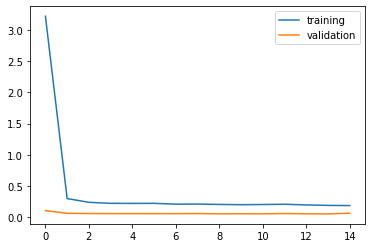

In [30]:
plt.plot(train_loss_ls,label ="training")
plt.plot(val_loss_ls,label='validation')
plt.legend()


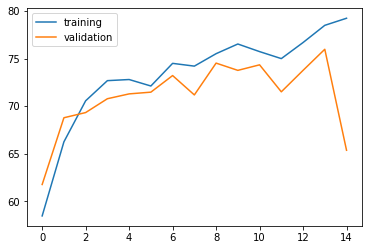

In [31]:
plt.plot(train_acc_ls,label ="training")
plt.plot(val_acc_ls,label='validation')
plt.legend()

In [37]:
"""
  model with
    He weight initialization
    dropout after convolution layers
    learning rate = 0.001
"""
after_cnn = CNN("He",'after_convolution_cnn',dropout_control=1).to(device)

train_loss_ls, val_loss_ls,train_acc_ls,val_acc_ls = fit(after_cnn , 0.001 , train_loader,val_loader)

test(after_cnn,test_loader)


epoch :  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


	Loss:1.8607759475708008 	 Accuracy:47.461%
	Loss:21.362865447998047 	 Accuracy:48.145%
	Loss:3.489461898803711 	 Accuracy:48.633%
	Loss:5.557184219360352 	 Accuracy:48.779%
	Loss:4.6567888259887695 	 Accuracy:49.023%
	Loss:1.6375923156738281 	 Accuracy:49.154%
	Loss:2.0721094608306885 	 Accuracy:49.386%
	Loss:2.174910306930542 	 Accuracy:49.756%
	Loss:1.5030021667480469 	 Accuracy:50.065%
	Loss:1.5142403841018677 	 Accuracy:50.156%
	Loss:2.2459564208984375 	 Accuracy:50.142%
	Loss:1.7672280073165894 	 Accuracy:50.553%
	Loss:1.4382760524749756 	 Accuracy:50.751%
	Loss:1.2981728315353394 	 Accuracy:50.935%
	Loss:1.517085313796997 	 Accuracy:50.768%
	Loss:1.5905754566192627 	 Accuracy:50.720%
	Loss:1.6255488395690918 	 Accuracy:50.712%
	Loss:1.3241214752197266 	 Accuracy:50.933%
	Loss:1.170819640159607 	 Accuracy:51.120%
	Loss:1.3914477825164795 	 Accuracy:50.977%
	Loss:1.2947413921356201 	 Accuracy:51.014%
	Loss:1.0612945556640625 	 Accuracy:51.143%
Train Loss:1.1715305560091442 	 Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test accuracy:70.52631578947368% 


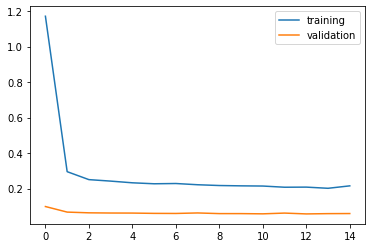

In [38]:
plt.plot(train_loss_ls,label ="training")
plt.plot(val_loss_ls,label='validation')
plt.legend()

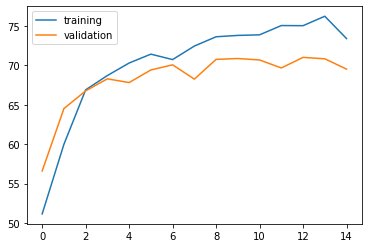

In [39]:
plt.plot(train_acc_ls,label ="training")
plt.plot(val_acc_ls,label='validation')
plt.legend()

In [34]:
"""
  model with
    He weight initialization
    dropout between fully connected layers
    learning rate = 0.001
"""
between_cnn = CNN("He",'between_convolution_cnn',dropout_control=2).to(device)

train_loss_ls, val_loss_ls,train_acc_ls,val_acc_ls = fit(between_cnn , 0.001 , train_loader,val_loader)

test(between_cnn,test_loader)

epoch :  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


	Loss:1.8273651599884033 	 Accuracy:52.539%
	Loss:15.078991889953613 	 Accuracy:51.465%
	Loss:10.428319931030273 	 Accuracy:50.586%
	Loss:2.4902753829956055 	 Accuracy:49.707%
	Loss:6.241466522216797 	 Accuracy:49.766%
	Loss:9.466363906860352 	 Accuracy:50.781%
	Loss:7.259081840515137 	 Accuracy:51.256%
	Loss:4.977631568908691 	 Accuracy:51.782%
	Loss:4.639891147613525 	 Accuracy:51.780%
	Loss:3.316793441772461 	 Accuracy:51.992%
	Loss:2.4770262241363525 	 Accuracy:52.255%
	Loss:2.6163315773010254 	 Accuracy:52.262%
	Loss:1.777841329574585 	 Accuracy:52.855%
	Loss:1.4612034559249878 	 Accuracy:52.999%
	Loss:1.3059377670288086 	 Accuracy:52.865%
	Loss:1.5785880088806152 	 Accuracy:52.856%
	Loss:1.7205567359924316 	 Accuracy:52.677%
	Loss:1.2709712982177734 	 Accuracy:52.658%
	Loss:1.2061471939086914 	 Accuracy:52.673%
	Loss:1.4096261262893677 	 Accuracy:52.568%
	Loss:1.4352831840515137 	 Accuracy:52.465%
	Loss:1.2586393356323242 	 Accuracy:52.386%
Train Loss:1.572792839472764 	 Train Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test accuracy:61.16152450090744% 


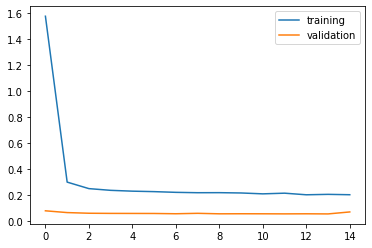

In [35]:
plt.plot(train_loss_ls,label ="training")
plt.plot(val_loss_ls,label='validation')
plt.legend()

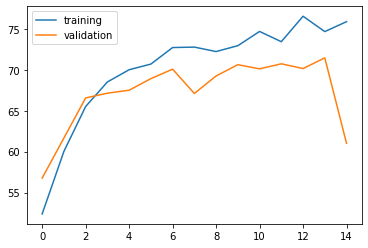

In [36]:
plt.plot(train_acc_ls,label ="training")
plt.plot(val_acc_ls,label='validation')
plt.legend()

In [40]:
"""
  model with
    He weight initialization
    L1 regularization
    learning rate = 0.001
"""
L1_cnn = CNN("He",'L1_cnn',dropout_control=0,regularization="L1",alpha=0.001).to(device)

train_loss_ls, val_loss_ls,train_acc_ls,val_acc_ls = fit(L1_cnn , 0.001 , train_loader,val_loader)

test(L1_cnn,test_loader)

epoch :  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


	Loss:4.967896461486816 	 Accuracy:52.734%
	Loss:12.569564819335938 	 Accuracy:52.441%
	Loss:6.981334686279297 	 Accuracy:53.451%
	Loss:15.091081619262695 	 Accuracy:52.637%
	Loss:9.147140502929688 	 Accuracy:52.617%
	Loss:5.614237308502197 	 Accuracy:54.264%
	Loss:5.566437244415283 	 Accuracy:53.962%
	Loss:5.995332717895508 	 Accuracy:53.247%
	Loss:4.89886474609375 	 Accuracy:54.102%
	Loss:5.126838207244873 	 Accuracy:54.570%
	Loss:5.7091264724731445 	 Accuracy:54.954%
	Loss:5.283263206481934 	 Accuracy:55.518%
	Loss:4.999595642089844 	 Accuracy:55.814%
	Loss:4.748267650604248 	 Accuracy:56.208%
	Loss:4.704556465148926 	 Accuracy:56.354%
	Loss:4.735808849334717 	 Accuracy:56.165%
	Loss:4.676799297332764 	 Accuracy:55.905%
	Loss:4.497260093688965 	 Accuracy:55.849%
	Loss:4.458280086517334 	 Accuracy:55.952%
	Loss:4.562411785125732 	 Accuracy:55.967%
	Loss:4.432185649871826 	 Accuracy:56.213%
	Loss:4.360029697418213 	 Accuracy:56.350%
Train Loss:2.4353822931962 	 Train Accuracy:56.350%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test accuracy:73.502722323049% 


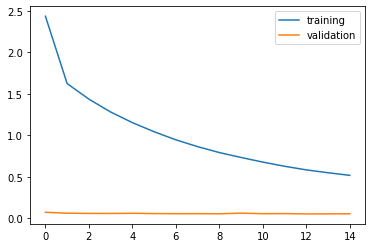

In [41]:
plt.plot(train_loss_ls,label ="training")
plt.plot(val_loss_ls,label='validation')
plt.legend()

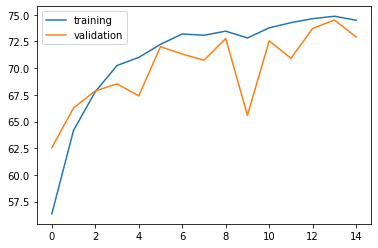

In [42]:
plt.plot(train_acc_ls,label ="training")
plt.plot(val_acc_ls,label='validation')
plt.legend()

In [43]:
"""
  model with
    He weight initialization
    L2 regularization
    learning rate = 0.001
"""
L2_cnn = CNN("He",'L2_cnn',dropout_control=0,regularization="L2",alpha=0.001).to(device)

train_loss_ls, val_loss_ls,train_acc_ls,val_acc_ls = fit(L2_cnn , 0.001 , train_loader,val_loader)

test(L2_cnn,test_loader)

epoch :  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


	Loss:1.2489230632781982 	 Accuracy:52.734%
	Loss:2.3404605388641357 	 Accuracy:54.590%
	Loss:11.666504859924316 	 Accuracy:53.190%
	Loss:5.399484157562256 	 Accuracy:52.539%
	Loss:1.2470760345458984 	 Accuracy:54.180%
	Loss:1.5576006174087524 	 Accuracy:54.167%
	Loss:2.569864273071289 	 Accuracy:53.069%
	Loss:1.951937198638916 	 Accuracy:52.026%
	Loss:2.708707094192505 	 Accuracy:52.127%
	Loss:2.2285776138305664 	 Accuracy:52.578%
	Loss:1.0896588563919067 	 Accuracy:53.569%
	Loss:2.5448529720306396 	 Accuracy:53.516%
	Loss:1.2319109439849854 	 Accuracy:54.492%
	Loss:1.7801218032836914 	 Accuracy:55.204%
	Loss:1.720340609550476 	 Accuracy:55.742%
	Loss:1.1171152591705322 	 Accuracy:56.433%
	Loss:1.8951351642608643 	 Accuracy:56.227%
	Loss:1.0127413272857666 	 Accuracy:56.836%
	Loss:1.3828784227371216 	 Accuracy:57.299%
	Loss:1.2138009071350098 	 Accuracy:57.754%
	Loss:0.9105707406997681 	 Accuracy:58.231%
	Loss:1.1889545917510986 	 Accuracy:58.282%
Train Loss:0.9187294443491643 	 Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test accuracy:73.10344827586206% 


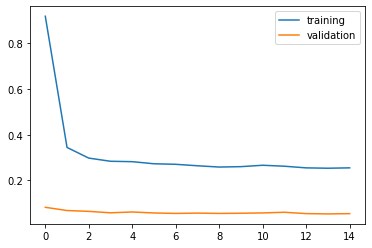

In [44]:
plt.plot(train_loss_ls,label ="training")
plt.plot(val_loss_ls,label='validation')
plt.legend()

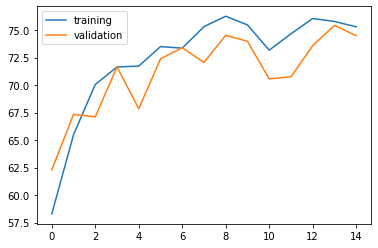

In [45]:
plt.plot(train_acc_ls,label ="training")
plt.plot(val_acc_ls,label='validation')
plt.legend()

#Reloading model

In [46]:
model = CNN("random","reloaded").to(device)
model.load_state_dict(torch.load("/zero_cnn.pkl"))
model.eval()
test(model,test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test accuracy:69.21960072595282% 


In [47]:
model = CNN("random","reloaded").to(device)
model.load_state_dict(torch.load("/random_cnn.pkl"))
model.eval()
test(model,test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test accuracy:69.36479128856624% 


In [48]:
model = CNN("random","reloaded").to(device)
model.load_state_dict(torch.load("/He_cnn.pkl"))
model.eval()
test(model,test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test accuracy:67.69509981851179% 


In [49]:
model = CNN("random","reloaded").to(device)
model.load_state_dict(torch.load("/after_convolution_cnn.pkl"))
model.eval()
test(model,test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test accuracy:70.52631578947368% 


In [50]:
model = CNN("random","reloaded").to(device)
model.load_state_dict(torch.load("/between_convolution_cnn.pkl"))
model.eval()
test(model,test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test accuracy:61.16152450090744% 


In [51]:
model = CNN("random","reloaded").to(device)
model.load_state_dict(torch.load("/L1_cnn.pkl"))
model.eval()
test(model,test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test accuracy:73.502722323049% 


In [52]:
model = CNN("random","reloaded").to(device)
model.load_state_dict(torch.load("/L2_cnn.pkl"))
model.eval()
test(model,test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test accuracy:73.10344827586206% 


In [53]:
model = CNN("random","reloaded").to(device)
model.load_state_dict(torch.load("/L2_cnn.pkl"))
model.eval()
test(model,test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test accuracy:73.10344827586206% 
